In [1]:
# Robot
# 20 x 21
# Best to be 20cm away for image recognition

# Obstacle
# 10 x 10
# Image will be on either of the 4 cardinal directions

# Grid
# Each square will represent a 10x10 square

# Dubins script source: https://github.com/FelicienC/RRT-Dubins

In [2]:
from dubins import Dubins
from map import GridMap

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Calculating Dubins Path (CSC)
# Major points in the path
# Start Position, End Position, Alpha (Point on current turning circle to stop), Beta (Point on target turning circle to stop)
# Extra points needed: Center point of both turning circles (Pt1 and Pt2)


# RSR and LSL Types
# Straight line dist = ( (Pt2[x] - Pt1[x])**2 + (Pt2[y] - Pt1[y])**2 ) ** 0.5

# Vector 1 = Vector from center of start circle to center of end circle = (V1[x], V1[y]) = (Pt2[x]-Pt1[x], Pt2[y]-Pt1[y])
# Vector 2 = Counterclockwise rotation of Vector 1 = (-V1[y], V1[x])

# Alpha[x] = Pt1[x] + (TurningRadius/StraightDist) * Vector 2[x]
# Alpha[y] = Pt1[y] + (TurningRadius/StraightDist) * Vector 2[y]

# Beta[x] = Alpha[x] + V1[x]
# Beta[y] = Alpha[y] + V1[y]


### RSL and LSR Types


In [4]:
directions = {
    'North': np.pi/2,
    'East': 2*np.pi,
    'South': (3*np.pi)/2,
    'West': np.pi
}

robotPositions = {
    'N': directions['South'],
    'E': directions['West'],
    'S': directions['North'],
    'W': directions['East']
}

obstacleList = [(11, 9, 'S'),
                (7, 15, 'S'),
                (6, 7, 'E'),
                (14, 14, 'E'),
                (1, 14, 'E')]

initPosition = (2, 2, directions['North'])

# First element represents the inital position the RC will be in
# Positions RC is expected to be in to accurately capture the image of the obstacles
# Obstacle Orientation to RC Position
# North:    Y-Axis + 2, Directions to be South
# East:     X-Axis + 2, Directions to be West
# South:    Y-Axis - 2, Directions to be North
# West:     X-Axis - 2, Directions to be East
positions = [initPosition,
            (11, 7, directions['North']),
            (7, 13, directions['North']),
            (8, 7, directions['West']),
            (16, 14, directions['West']),
            (1, 14, directions['West'])]

# Possible positions RC will complete its pathing in
finalPositions = [(1, 1, directions['South']),
                  (1, 2, directions['West'])]

In [5]:
map = GridMap([20, 20])
for ob in obstacleList:
    map.setObstacles(ob)

In [6]:
map.printGrid()

['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', 'E', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'S', '.', '.', '.', '.', '.', '.', 

In [7]:
local_planner = Dubins(2.5, .5)

adjMat = []

for start in positions:
    paths = []

    for dst in positions:
        if dst != start and dst != initPosition:
            # Tuple: (Total_Dist, Specific_Dist, Pathing)
            pathing = local_planner.dubins_path(start, dst, map)
            paths.append(pathing if pathing else 0)

    if start != initPosition:
        finalPos0 = local_planner.dubins_path(start, finalPositions[0], map)
        finalPos1 = local_planner.dubins_path(start, finalPositions[1], map)

        paths.append(finalPos0 if finalPos0[0] < finalPos1[0] else finalPos1)
        # paths.append(min(local_planner.dubins_path(start, finalPositions[0], map), local_planner.dubins_path(start, finalPositions[1], map)))

    adjMat.append(paths)

c:\Users\hiast\Desktop\School\Y2S2\SC2079 - MDP\SC2079-MDP\Python\Dubins\dubins.py:521: RuntimeWarning: invalid value encountered in double_scalars
  *(4*self.radius**2-(intercenter/2)**2)**.5


[11.853981633974483, (-1.5707963267948966, 1.5707963267948968, 4.0), array([[ 2.        ,  2.        ],
       [ 2.04983356,  2.49667333],
       [ 2.19734751,  2.97354586],
       [ 2.43666096,  3.41160618],
       [ 2.75823323,  3.79339023],
       [ 3.14924424,  4.10367746],
       [ 3.59410561,  4.33009771],
       [ 4.07508214,  4.46362432],
       [ 4.57300918,  4.5       ],
       [ 5.07300918,  4.5       ],
       [ 5.57300918,  4.5       ],
       [ 6.07300918,  4.5       ],
       [ 6.57300918,  4.5       ],
       [ 7.07300918,  4.5       ],
       [ 7.57300918,  4.5       ],
       [ 8.07300918,  4.5       ],
       [ 8.57299881,  4.50106599],
       [ 9.06800524,  4.56538092],
       [ 9.54036709,  4.72675643],
       [ 9.97125279,  4.97875899],
       [10.34348429,  5.31134205],
       [10.64222188,  5.71124657],
       [10.85555585,  6.16252962],
       [10.97498124,  6.64719998],
       [11.        ,  7.        ]])]
[12.15726815753092, (-0.4718618372796417, 0.4718618372

TypeError: 'int' object is not subscriptable

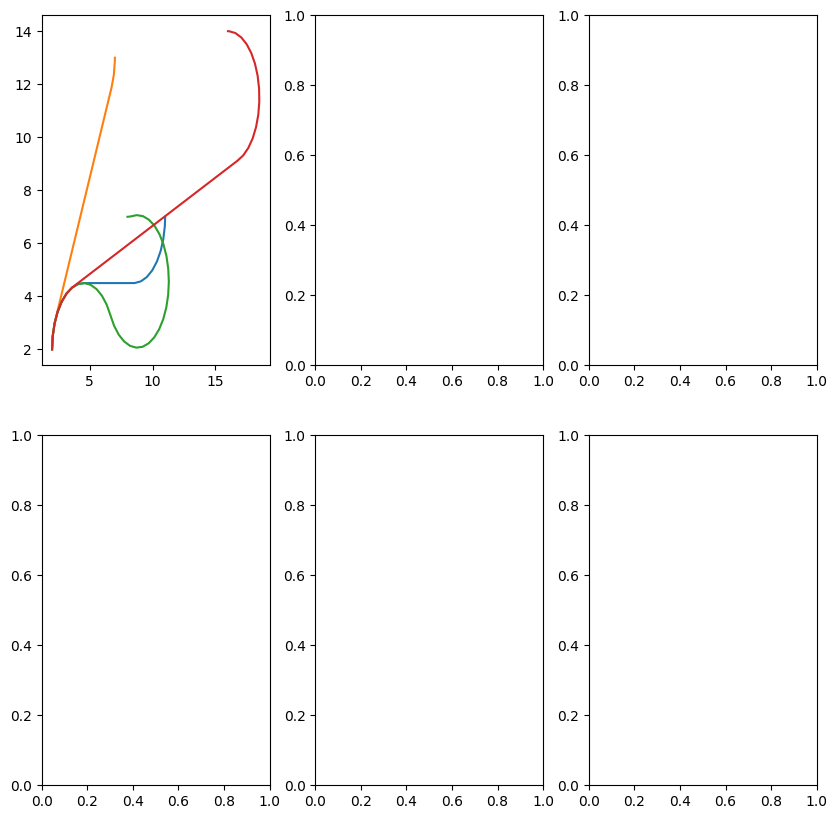

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]

# plt.grid()
# plt.xticks(np.arange(0, 21, 1.0))
# plt.yticks(np.arange(0, 21, 1.0))
# for path in adjMat[0]:
#     pathing = path[2]
#     plt.plot(pathing[:, 0], pathing[:, -1])

fig, ax = plt.subplots(2, 3)

for path in adjMat[0]:
    if path == 0: continue

    pathing = path[2]
    ax[0, 0].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[1]:
    if path == 0: continue

    pathing = path[2]
    ax[0, 1].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[2]:
    if path == 0: continue

    pathing = path[2]
    ax[0, 2].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[3]:
    if path == 0: continue

    pathing = path[2]
    ax[1, 0].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[4]:
    if path == 0: continue

    pathing = path[2]
    ax[1, 1].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[5]:
    if path == 0: continue
    
    pathing = path[2]
    ax[1, 2].plot(pathing[:, 0], pathing[:, -1])

plt.show()